In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
df = pd.read_csv('Data/monthlyreturncapitalization.csv')
df['Monthly Calendar Date'] = pd.to_datetime(df['Monthly Calendar Date'])
df = df.sort_values(['Ticker', 'Monthly Calendar Date'])
df = df.drop_duplicates(subset=['Ticker', 'Monthly Calendar Date'], keep='last')

returns = df.pivot(index='Monthly Calendar Date', columns='Ticker', values='Monthly Total Return')
mcap = df.pivot(index='Monthly Calendar Date', columns='Ticker', values='Monthly Market Capitalization')

rf = pd.read_csv('Data/riskfree.csv')
rf['Calendar Date'] = pd.to_datetime(rf['Calendar Date'])
rf = rf.set_index('Calendar Date')['90 Day Bill Returns']

mkt = pd.read_csv('Data/marketreturn.csv')
mkt['Date'] = pd.to_datetime(mkt['Date'])
mkt = mkt.set_index('Date')['Total Market'].str.rstrip('%').astype(float) / 100

/var/folders/l_/8zvg9_s54490f5lkvsgxjvjh0000gn/T/ipykernel_78098/1312314194.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Monthly Calendar Date'] = pd.to_datetime(df['Monthly Calendar Date'])
/var/folders/l_/8zvg9_s54490f5lkvsgxjvjh0000gn/T/ipykernel_78098/1312314194.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rf['Calendar Date'] = pd.to_datetime(rf['Calendar Date'])


In [3]:
def estimate_covariance_sample(ret_window):
    return ret_window.cov()

def estimate_covariance_single_factor(ret_window, mkt_ret):
    betas = []
    residual_vars = []
    for col in ret_window.columns:
        y = ret_window[col].dropna()
        x = mkt_ret.loc[y.index]
        valid = ~(y.isna() | x.isna())
        y, x = y[valid], x[valid]
        if len(y) > 1:
            beta = np.cov(x, y)[0,1] / np.var(x)
            residual = y - beta * x
            residual_var = np.var(residual)
        else:
            beta = 0
            residual_var = np.var(y) if len(y) > 0 else 1e-4
        betas.append(beta)
        residual_vars.append(residual_var)
    
    betas = np.array(betas)
    var_mkt = np.var(mkt_ret.loc[ret_window.index].dropna())
    cov_matrix = np.outer(betas, betas) * var_mkt + np.diag(residual_vars)
    return pd.DataFrame(cov_matrix, index=ret_window.columns, columns=ret_window.columns)

def estimate_covariance_constant_corr(ret_window):
    corr_matrix = ret_window.corr()
    avg_corr = corr_matrix.where(~np.eye(len(corr_matrix), dtype=bool)).stack().mean()
    std_devs = ret_window.std()
    n = len(std_devs)
    cov_matrix = np.outer(std_devs, std_devs) * avg_corr
    np.fill_diagonal(cov_matrix, std_devs**2)
    return pd.DataFrame(cov_matrix, index=ret_window.columns, columns=ret_window.columns)

def estimate_covariance_shrinkage(ret_window, delta=0.5):
    sample_cov = ret_window.cov()
    std_devs = ret_window.std()
    avg_var = np.mean(np.diag(sample_cov))
    target = np.eye(len(std_devs)) * avg_var
    shrunk_cov = delta * target + (1 - delta) * sample_cov.values
    return pd.DataFrame(shrunk_cov, index=ret_window.columns, columns=ret_window.columns)

In [4]:
def optimize_min_variance(cov_matrix):
    n = len(cov_matrix)
    
    def objective(w):
        return w @ cov_matrix.values @ w
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    w0 = np.ones(n) / n
    
    result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    return pd.Series(result.x, index=cov_matrix.columns)

In [5]:
estimation_window = 60
start_estimation = returns.index[0]
first_oos = returns.index[estimation_window]

start_date = '2017-01-01'
end_date = '2022-12-31'

oos_dates = returns.loc[start_date:end_date].index

results = {
    'sample': [],
    'single_factor': [],
    'constant_corr': [],
    'shrinkage': [],
    'equal_weight': [],
    'value_weight': []
}

for date in oos_dates:
    date_idx = returns.index.get_loc(date)
    if date_idx < estimation_window:
        continue
    
    ret_window = returns.iloc[date_idx - estimation_window:date_idx]
    ret_window = ret_window.dropna(axis=1, how='all')
    
    ret_oos = returns.loc[date, ret_window.columns]
    
    mkt_window = mkt.loc[ret_window.index]
    
    cov_sample = estimate_covariance_sample(ret_window)
    cov_single = estimate_covariance_single_factor(ret_window, mkt_window)
    cov_const = estimate_covariance_constant_corr(ret_window)
    cov_shrink = estimate_covariance_shrinkage(ret_window)
    
    w_sample = optimize_min_variance(cov_sample)
    w_single = optimize_min_variance(cov_single)
    w_const = optimize_min_variance(cov_const)
    w_shrink = optimize_min_variance(cov_shrink)
    
    w_equal = pd.Series(1.0 / len(ret_window.columns), index=ret_window.columns)
    
    mcap_prev = mcap.iloc[date_idx - 1, :]
    mcap_prev = mcap_prev[ret_window.columns].fillna(0)
    w_value = mcap_prev / mcap_prev.sum()
    
    results['sample'].append((date, (w_sample * ret_oos).sum()))
    results['single_factor'].append((date, (w_single * ret_oos).sum()))
    results['constant_corr'].append((date, (w_const * ret_oos).sum()))
    results['shrinkage'].append((date, (w_shrink * ret_oos).sum()))
    results['equal_weight'].append((date, (w_equal * ret_oos).sum()))
    results['value_weight'].append((date, (w_value * ret_oos).sum()))

In [6]:
portfolio_returns = {}
for strategy, res in results.items():
    portfolio_returns[strategy] = pd.Series([r[1] for r in res], index=[r[0] for r in res])

returns_df = pd.DataFrame(portfolio_returns)

In [7]:
def calculate_metrics(ret_series, rf_series):
    cumulative = (1 + ret_series).cumprod()
    total_return = cumulative.iloc[-1] - 1
    ann_return = (1 + total_return) ** (12 / len(ret_series)) - 1
    ann_vol = ret_series.std() * np.sqrt(12)
    
    rf_aligned = rf_series.loc[ret_series.index]
    excess = ret_series - rf_aligned
    sharpe = excess.mean() / excess.std() * np.sqrt(12)
    
    cummax = cumulative.cummax()
    drawdown = (cumulative - cummax) / cummax
    max_dd = drawdown.min()
    
    return {
        'Total Return': total_return,
        'Ann. Return': ann_return,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

metrics = {}
for strategy in returns_df.columns:
    metrics[strategy] = calculate_metrics(returns_df[strategy], rf)

metrics_df = pd.DataFrame(metrics).T
metrics_df

,Total Return,Ann. Return,Ann. Volatility,Sharpe Ratio,Max Drawdown
sample,1.409011,0.157817,0.172699,0.869143,-0.237540
single_factor,0.673228,0.089580,0.161839,0.541274,-0.326044
constant_corr,1.079050,0.129737,0.135181,0.883111,-0.153209
shrinkage,1.454963,0.161469,0.162621,0.931272,-0.223708
equal_weight,1.924131,0.195821,0.175602,1.040595,-0.213848
value_weight,1.453331,0.161340,0.179021,0.859550,-0.251509


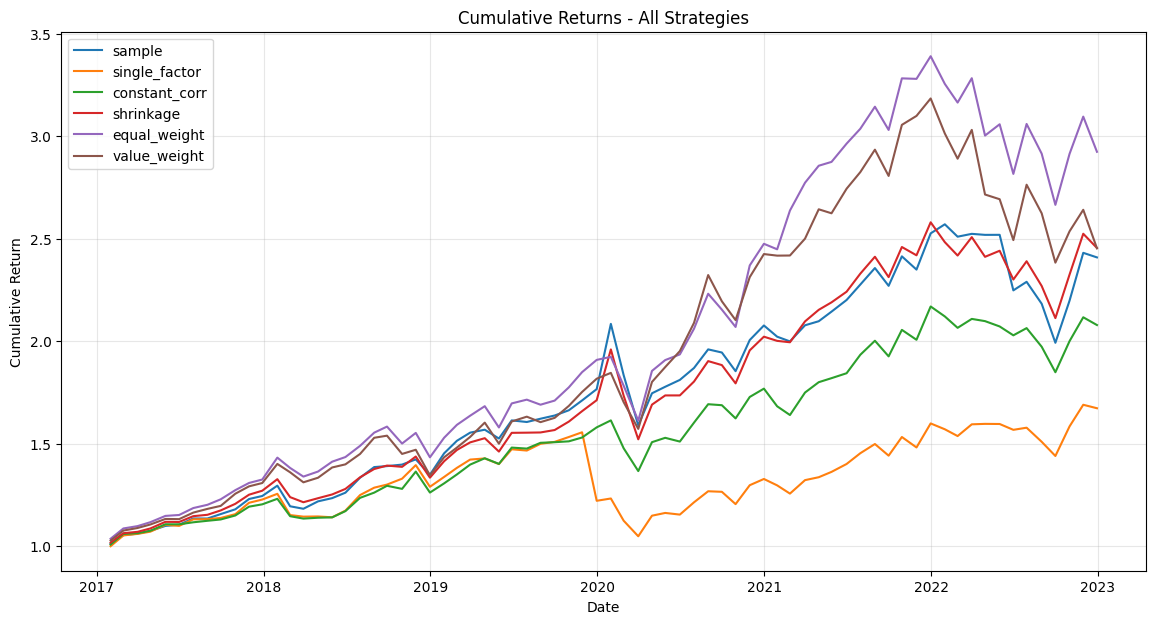

In [8]:
cumulative_returns = (1 + returns_df).cumprod()

plt.figure(figsize=(14, 7))
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
plt.legend()
plt.title('Cumulative Returns - All Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.show()